In [ ]:
from hashlib import sha256
from random import SystemRandom
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from sage.all import *

n = 100
m = 100
q = 7
FF = GF(q)

# apply1: Thực hiện nhân từng ma trận cho trước với một vector cột v: v^t.F[i].v. Kết quả trả về là một vector cột theo module GF(7)
def apply1(F, v):
    out = []
    for i in range(m):
        out.append((v.T * F[i] * v)[0, 0])
    return matrix(FF, out).T

# Hàm này tương tự như apply1, nhưng nó thực hiện phép nhân với ma trận F[i] + F[i].T (ma trận cộng với ma trận chuyển vị của nó) và vectơ s.
def apply2(F, t, s):
    out = []
    for i in range(m):
        out.append((t.T * (F[i] + F[i].T) * s)[0, 0])
    return matrix(FF, out).T

def gen(v, s, F):
    output = []
    for _ in range(9):
        t = matrix(FF, [FF.random_element() for _ in range(n)]).T
        com = apply1(F, t)
        verif = apply2(F, t, s)
        a = sha256(bytes([int(i) for i in com.list() + v.list() + verif.list()])).digest()[0] % q
        output.append((com, t - a * s, verif))
    return output

def encrypt_flag(s):
    flag = open("flag.txt", "rb").read()
    key = sha256(str([int(i) for i in s.list()]).encode()).digest()
    cipher = AES.new(key, AES.MODE_CBC)
    ct = cipher.encrypt(pad(flag, 16))
    return ct, cipher.iv

rng = SystemRandom()

seed = [rng.randint(0, 255) for _ in range(64)]
gen_seed = bytes(seed)

F = []
for i in range(m):
    cur = []
    for j in range(n):
        cur.append([])
        for k in range(n):
            cur[-1].append(sha256(gen_seed).digest()[0] % q)
            gen_seed = sha256(gen_seed).digest()
    F.append(matrix(FF, n, n, cur))

s = random_matrix(FF, n, 1)	

v = apply1(F, s)
output = gen(v, s, F)

coms = [pi[0].list() for pi in output]
tass = [pi[1].list() for pi in output]
verifs = [pi[2].list() for pi in output]

ct, iv = encrypt_flag(s)

f = open("output.txt", "w")
f.write(f"{seed = }\n")
f.write(f"v = {[int(i) for i in v.list()]}\n")
f.write(f"{coms = }\n")
f.write(f"{tass = }\n")
f.write(f"{verifs = }\n")
f.write(f"{ct = }\n")
f.write(f"{iv = }")
f.close()

In [ ]:
with open('output.txt', 'r') as output:
    out_lst = output.readlines()

# Trich xuat thanh cacs bien tuong ung
for line in out_lst:
    exec(line)               # seed, v, coms, tass, verifs, ct, iv
# print(seed, type(seed))
gen_seed = bytes(seed)

F = []
for i in range(m):
    cur = []
    for j in range(n):
        cur.append([])
        for k in range(n):
            cur[-1].append(sha256(gen_seed).digest()[0] % q)
            gen_seed = sha256(gen_seed).digest()
    F.append(matrix(FF, n, n, cur))
    
# Chuyen cac bien thanh ma tran
v = matrix(FF, v).T
coms = [matrix(FF, com).T for com in coms]
tass = [matrix(FF, tas).T for tas in tass]
verifs = [matrix(FF, verif).T for verif in verifs]

print(f"v: {v.nrows()}, {v.ncols()}")
print(f"com: {coms[0].nrows()}, {coms[0].ncols()}")
print(f"tas: {tass[0].nrows()}, {tass[0].ncols()}")
print(f"verif: {verifs[0].nrows()}, {verifs[0].ncols()}")


In [ ]:
def apply3(F, tass):
    out = []
    for i in range(m):
        tempM = tass.T*(F[i]+F[i].T)
        out.append(tempM.list())
#         print(tempM)
#         print(out)
    return matrix(FF, out)

def calculator_s(com, verif, tas):
    a = sha256(bytes([int(i) for i in com.list() + v.list() + verif.list()])).digest()[0] % q
    temp = verif - 2*a*v
    M_inv = None
    try:
        M_inv = apply3(F, tas).inverse()
    except ZeroDivisionError:
        print("Ma trận không khả nghịch, bỏ qua...")
        return None
    
    s = M_inv * temp if M_inv is not None else None
    return s

# def decrypt_flag(s, iv, ct):
#     key = sha256(str([int(i) for i in s.list()]).encode()).digest()
#     cipher = AES.new(key, AES.MODE_CBC, iv)
#     flag = unpad(cipher.decrypt(ct), 16)
#     return flag

def decrypt_flag(s, iv, ct):
    key = sha256(str([int(i) for i in s.list()]).encode()).digest()
    cipher = AES.new(key, AES.MODE_CBC, iv)
    try:
        flag = unpad(cipher.decrypt(ct), 16)
        return flag
    except ValueError as e:
        if "Padding is incorrect" in str(e):
            return None
        else:
            raise e

for i in range(9):
    s = calculator_s(coms[i], verifs[i], tass[i])
    if s is None:
        continue
    flag = decrypt_flag(s, iv, ct)
    print(flag)
    print()

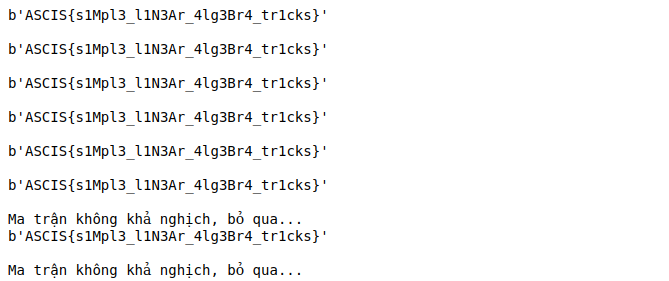